# Analyze A/B Test Results
___________________________
## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Extra - Time Influence](#time_influence)


<a id='intro'></a>
## Introduction

A company of an e-commerce website wants to understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<br>The following is the data dictionary of the dataset 'ab_data':
> **01 - user_id<br>**
Unique ID<br>
**02 - timestamp<br>**
Time stamp when the user visited the webpage<br>
**03 - group<br>**
In the current A/B experiment, the users are categorized into two broad groups.<br>
The control group users are expected to be served with old_page, and treatment group users are matched with the new_page.<br>
**04 - landing_page<br>**
It denotes whether the user visited the old or new webpage.<br>
**05 - converted<br>**
It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.<br>

<br>The following is the data dictionary of the dataset 'countries.csv': 
>**01 - user_id<br>**
Unique ID.<br>
**02 - country<br>**
The country where the user lives in.<br>




<a id='probability'></a>
## Part I - Probability

Importing required libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

#Setting the seed to have consistent results for each run
random.seed(42)

Reading in the dataset and taking a look at the top few rows:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Finding the number of rows in the dataset and other information.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

The proportion of users converted.

In [5]:
conv_pr = df.query('converted == 1')['user_id'].nunique() / df['user_id'].nunique()
conv_pr

0.12104245244060237

The number of times the `new_page` and `treatment` don't line up.

In [6]:
mismatched = df.query('(landing_page == "new_page" and group != "treatment") or\
                       (landing_page != "new_page" and group == "treatment")').shape[0]
mismatched

3893

Checking for any missing values in the rows

In [7]:
missing = df.isnull().any(axis = 1).sum()
missing

0

Creating a new dataframe with only records that have `new_page` and `treatment` lined up.

In [8]:
df2 = df.query('(landing_page == "new_page" and group == "treatment") or\
                (landing_page == "old_page" and group == "control")')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


Checking that all of the correct rows were removed

In [9]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Number of unique **user_id**s in the new dataset

In [10]:
df2['user_id'].nunique()

290584

Checking for duplicated users

In [11]:
dup_usr = df2[df2['user_id'].duplicated()]['user_id']
dup_usr.values[0]

773192

Viewing the row information for the duplicated **user_id**? 

In [12]:
df2[df2['user_id'] == dup_usr.values[0]]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing **one** of the rows with a duplicate **user_id**

In [13]:
df2 = df2.drop_duplicates(subset='user_id')
df2[df2['user_id'] == dup_usr.values[0]]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


The probability of an individual converting regardless of the page they receive?

In [14]:
converted = df2.query('converted == 1').shape[0] / df2.shape[0]
converted

0.11959708724499628

Given that an individual was in the `control` group, the probability they converted is:

In [15]:
conv_ctr = df2.query('converted == 1 and group == "control"').shape[0] / df2.query('group == "control"').shape[0]
conv_ctr

0.1203863045004612

Given that an individual was in the `treatment` group, the probability they converted is:

In [16]:
conv_trm = df2.query('converted == 1 and group == "treatment"').shape[0] / df2.query('group == "treatment"').shape[0]
conv_trm

0.11880806551510564

Observed difference in the two probabilities that will be used later in the sampling distribution

In [17]:
obs_diff = conv_trm - conv_ctr
obs_diff

-0.0015782389853555567

The probability that an individual received the new page:

In [18]:
new_page = df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]
new_page

0.5000619442226688

### Question
Is there sufficient evidence to say that the new treatment page leads to more conversions ?

### Answer
>As the observed difference between the treatment and control group for the conversion rate is < 0, this suggests that the new treatment page does not lead to more conversions.
Also, based on the last calculation, there is an equal propotion of treatment and control groups, each with 50%  which implies that there is no bias in the data.
However, we cannot be certain of the conclusion unless we do a confidence or hypothises testing.

<a id='ab_test'></a>
## Part II - A/B Test


By assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%,<br>
the null and alternative hypotheses are as following:

>**$H_{0}$** : **$p_{new}$** - **$p_{old}$** <= 0 <br>
**$H_{1}$** : **$p_{new}$** - **$p_{old}$** > 0

Where:<br>
**$p_{old}$** : the conversion rate of the old page,<br>
**$p_{new}$** : the conversion rate of the new page.<br>
**$H_{0}$** : the null hypotheses that states the new page has less than or equal conversion rate as of the old page,<br>
**$H_{1}$** : the alternative hypotheses that states the new page has higher conversion rate than the old page.<br>

____________
Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Then, we will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

The **convert rate** for $p_{new}$ under the null:

In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

The **convert rate** for $p_{old}$ under the null:

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

The size of new_page $n_{new}$ :

In [21]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

The size of old_page $n_{old}$:

In [22]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.

In [23]:
new_page_converted = np.random.binomial(n=1, p=p_new, size=n_new)

Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. 

In [24]:
old_page_converted = np.random.binomial(n=1, p=p_old, size=n_old)

$p_{new}$ - $p_{old}$ for the simulated values:

In [25]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0011953774033828662

Now, simulating 10,000 $p_{new}$ - $p_{old}$ values:

In [26]:
p_new = df2.query('landing_page == "new_page"').converted.mean()
p_old = df2.query('landing_page == "old_page"').converted.mean()

### Remarks
>Updated the conversion rates for treatment(new page) and control(old page) because: <br>
The previous questions were asking for the following hypotheses (two-sided):<br>
**$H_{0}$** : **$p_{new}$** - **$p_{old}$**  = 0 <br>
**$H_{1}$** : **$p_{new}$** - **$p_{old}$** != 0<br>
<br>However, it is more reasonable to have the following hypotheses (one-sided test)<br>
that we have defined previously:<br>
**$H_{0}$** : **$p_{new}$** - **$p_{old}$** <= 0 <br>
**$H_{1}$** : **$p_{new}$** - **$p_{old}$** > 0

In [27]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)    
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

#size = df2.shape[0]
#for _ in range(10000):    
#    bootstrap = df2.sample(size, replace=True)
#    new_page_converted = bootstrap.query('landing_page == "new_page"').converted
#    old_page_converted = bootstrap.query('landing_page == "old_page"').converted
#    diff = new_page_converted.mean() - old_page_converted.mean()
#    p_diffs.append(diff)    

Ploting a histogram of the **p_diffs** (the probability difference of the two pages)

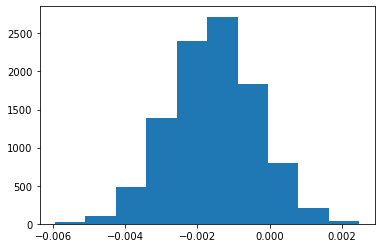

In [28]:
plt.hist(p_diffs);

Calculating the proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**?

In [29]:
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), 10000)

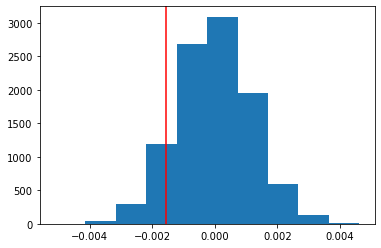

In [30]:
plt.hist(null_vals);
plt.axvline(obs_diff, color='r')

In [31]:
p_val = (null_vals > obs_diff).mean()
p_val

0.9056

### Remarks
>We have computed the p-value by the sampling distribution under the null which in this case is 0.<br>
This is because we need to reach to the conclusion whether we are able to reject the null hypotheses or we fail to.<br>
To acheive so, we calculated the p-value using the one-sided test of the null values > the observed difference.(because of the "greater than" in the alternative hypotheses)<br>
As the p-value represents the propotion of the variance described by the distribution of the null hypotheses and since the p-value obtained is 0.9033 > 0.05, this shows that most of the variance is described by the null and therefore, we fail to reject the null hypotheses.

Trying with a built-in to achieve similar results. 

In [32]:
convert_old = df2.query('landing_page == "old_page" and converted == 1')['user_id'].count()
convert_new = df2.query('landing_page == "new_page" and converted == 1')['user_id'].count()
n_old = n_old
n_new = n_new

Computing test statistic and p-value.

In [33]:
count = [convert_new, convert_old]
nobs = [n_new, n_old]
zstat, p_value = sm.stats.proportions_ztest(count=count, nobs=nobs, alternative='larger')
print('test statistic for the z-test: ', zstat)
print('p-value for the z-test: ', p_value)

test statistic for the z-test:  -1.3109241984234394
p-value for the z-test:  0.9050583127590245


### Remarks
>As the observed difference is -0.00158 < 0, the $Z_{score}$ is -1.31 < 0 which is consistent<br>
We have p-value 0.9050 which is almost equals to our calculated p-values of 0.9033<br>
Since this is a right-tailed test, to reject the null hypotheses, this must be true $Z_{score}$ > $Z_{\alpha}$<br>
$Z_{0.05}$ = 1.645 (one-tailed test), $Z_{score}$ = 0.08851<br>
These values confirms our conclusion that we fail to reject the null hypotheses



<a id='regression'></a>
## Part III - A regression approach

Since we need to know whether the user converted or not which is a binary categorical outcome, logistic regression will be used here.

We will fit the regression model with **statsmodels** to see if there is a significant difference in conversion based on which page a customer receives.<br>
Two new columns will be added:<br>
**ab_page** : which is 1 when an individual receives the **treatment** and 0 if **control**.<br>
**intercept** : which represents the intercept of the line

In [34]:
df2['intercept'] = 1
df2[['ab_page', 'ab_page_old']] = pd.get_dummies(df2['landing_page'])
df2.drop('ab_page_old', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Instantiating and fitting the model to predict whether or not an individual converts.

In [35]:
logit_m = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_m.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


The result summary of the model

In [36]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-03-15 20:28 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

### Remarks
>The p-value is 0.1899, which is expected as the logistic regression performs two-sided test, that is it tests the following hypotheses:<br>
**$H_{0}$** : **$p_{new}$** - **$p_{old}$**  = 0 <br>
**$H_{1}$** : **$p_{new}$** - **$p_{old}$** != 0<br>
<br>However, in the previous question we performed one-sided test (right-tailed ">") to test the following hypotheses:<br>
**$H_{0}$** : **$p_{new}$** - **$p_{old}$** <= 0<br>
**$H_{1}$** : **$p_{new}$** - **$p_{old}$** > 0<br>
<br>Therefore, we obtained different p-values. Appearently, the direcition of the test doesn't affect the z-score as in both cases they are equal.<br>
Since p-value > ${\alpha}$=0.05, we fail to reject the null hypotheses, too, i.s. we fail to reject **$H_{0}$** : **$p_{new}$** - **$p_{old}$**  = 0

### Considering Other Factors
>There are many factors that can be considered and are important as well.<br>
One can be:<br>
- Type of user: is it an exisitng or a new user ?<br>
This quesion is important because of the two phenomena known as change aversion and novelty effect. Therefore, we need to account for and have a good propotion of each type. This brings us to the second factor:<br> 
- Duration: to minimize the change aversion and novelty effect, we need to run the test long enough and then examine the results.

>Adding additional terms might have negative effects, such as in cases where there are multicollinearity between the terms.<br>
Therefore, we need to examine any additional terms by using Variance Inflation Facotor (VIF) and remove one of the terms that have high VIF


### Country Impact on Conversion (using the second dataset)

In [37]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [38]:
dummy_cols = np.sort(df_new['country'].unique())
dummy_cols

array(['CA', 'UK', 'US'], dtype=object)

In [39]:
### Create the necessary dummy variables
df_new[dummy_cols] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [40]:
country_conv = df_new.groupby('country', as_index=False).converted.mean()
country_conv

,country,converted
0,CA,0.115318
1,UK,0.120594
2,US,0.119547


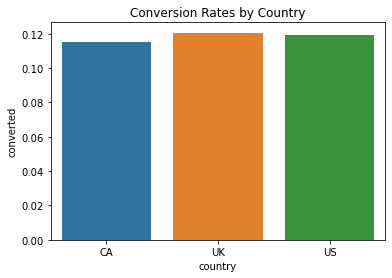

In [41]:
sns.barplot(x=country_conv['country'], y=country_conv['converted'])
plt.title('Conversion Rates by Country');

In [42]:
page_conv = df_new.groupby('landing_page', as_index=False).converted.mean()
page_conv

,landing_page,converted
0,new_page,0.118808
1,old_page,0.120386


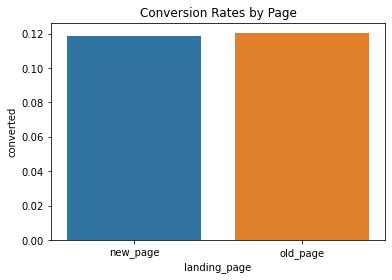

In [43]:
sns.barplot(x=page_conv['landing_page'], y=page_conv['converted'])
plt.title('Conversion Rates by Page');

### Remarks
>It seems that the country has an effect on conversion rates. We can see that CA has the lowest conversion rate and UK has the highest.<br>
Also, as calculated previously, page has an effect as well.<br>
Next we will see the interaction of the two.

### Interaction of Page and Country

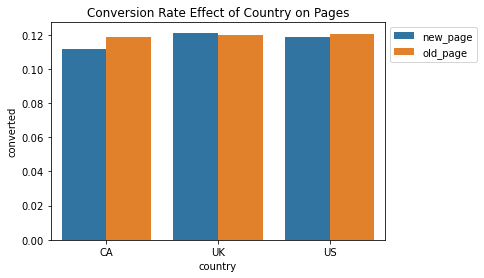

In [44]:
page_country = df_new.groupby(['country', 'landing_page'], as_index=False).converted.mean()
sns.barplot(x=page_country['country'], y=page_country['converted'], hue=page_country['landing_page'])
plt.title('Conversion Rate Effect of Country on Pages');
plt.legend(bbox_to_anchor=(1, 1), loc=2);

### Remarks
>We can see that the behaviour of the two pages for the conversion rates is affected by country.<br>
This suggests that we should examine the interaction of the two.<br>
Since CA is the baseline, only UK and US will be used.

In [45]:
df_new['page_uk'] = df_new['ab_page'] * df_new['UK']
df_new['page_us'] = df_new['ab_page'] * df_new['US']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,page_uk,page_us
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [46]:
### Fit Your Linear Model And Obtain the Results
int_logit_m = sm.Logit(df_new['converted'], df_new[['intercept', 'page_uk', 'page_us', 'ab_page', 'UK', 'US']])
results = int_logit_m.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [47]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-03-15 20:28 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
page_uk        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
page_us        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
==================================================================

"""

### Remarks
>Since p-value > ${\alpha}$=0.05 for all predictors, we fail to reject the null hypotheses and none of the predictors is statistically significant in predicting the conversion

<a id='time_influence'></a>
## Exploring and examining influences associated with time on conversion

In [48]:
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])
df_new['date'] = pd.to_datetime(df_new['timestamp'].dt.date)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 834778 to 934996
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country       290584 non-null  object        
 1   timestamp     290584 non-null  datetime64[ns]
 2   group         290584 non-null  object        
 3   landing_page  290584 non-null  object        
 4   converted     290584 non-null  int64         
 5   intercept     290584 non-null  int64         
 6   ab_page       290584 non-null  uint8         
 7   CA            290584 non-null  uint8         
 8   UK            290584 non-null  uint8         
 9   US            290584 non-null  uint8         
 10  page_uk       290584 non-null  uint8         
 11  page_us       290584 non-null  uint8         
 12  date          290584 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3), uint8(6)
memory usage: 19.4+ MB


In [49]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,page_uk,page_us,date
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,2017-01-14
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1,2017-01-23
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0,2017-01-16
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,2017-01-22
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0,2017-01-16


In [50]:
df_new.groupby('date')['country'].count()

date
2017-01-02     5712
2017-01-03    13208
2017-01-04    13119
2017-01-05    12932
2017-01-06    13353
2017-01-07    13213
2017-01-08    13387
2017-01-09    13243
2017-01-10    13350
2017-01-11    13361
2017-01-12    13159
2017-01-13    13060
2017-01-14    13147
2017-01-15    13263
2017-01-16    13136
2017-01-17    13155
2017-01-18    13085
2017-01-19    13130
2017-01-20    13213
2017-01-21    13309
2017-01-22    13265
2017-01-23    13349
2017-01-24     7435
Name: country, dtype: int64

### Remarks
>It seems that the data is collected for january only, and so we will take dummy variables based on the number of the week of january

In [51]:
### Getting the week number 
df_new['week_no'] = df_new['date'].map(lambda date: np.ceil(date.day / 7).astype('int'))
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,page_uk,page_us,date,week_no
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,2017-01-14,2
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1,2017-01-23,4
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0,2017-01-16,3
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,2017-01-22,4
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0,2017-01-16,3


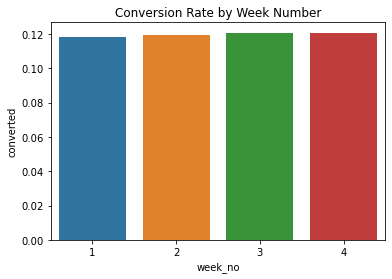

In [52]:
conv_by_week = df_new.groupby('week_no', as_index=False).converted.mean()
sns.barplot(x=conv_by_week['week_no'], y=conv_by_week['converted'])
plt.title('Conversion Rate by Week Number');

In [53]:
### Create the necessary dummy variables
df_new[['week1', 'week2', 'week3', 'week4']] = pd.get_dummies(df_new['week_no'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,page_uk,page_us,date,week_no,week1,week2,week3,week4
user_id,,,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,2017-01-14,2,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1,2017-01-23,4,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0,2017-01-16,3,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,2017-01-22,4,0,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0,2017-01-16,3,0,0,1,0


In [54]:
### Fitting the model
time_logit_m = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'page_uk', 'page_us',\
                                             'week2', 'week3', 'week4']])
results = time_logit_m.fit()

Optimization terminated successfully.
         Current function value: 0.366105
         Iterations 6


In [55]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212786.5020
Date:               2022-03-15 20:28 BIC:              212881.7188
No. Observations:   290584           Log-Likelihood:   -1.0638e+05
Df Model:           8                LL-Null:          -1.0639e+05
Df Residuals:       290575           LLR p-value:      0.29676    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0153    0.0378  -53.3206  0.0000  -2.0894  -1.9412
ab_page       -0.0673    0.0520   -1.2938  0.1957  -0.1692   0.0346
UK             0.0118    0.0398    0.2960  0.7672  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
page_uk        0.0783    0.0568    1.3781  0.1682  -0.0330   0.1896
page_us        0.0467    0.0538    0.8689  0.3849  -0.0587   0.1521
week2          0.0077    0.0154    0.5008  0.6165  -0.0224   0.0379
week3          0.0195    0.0154    1.2709  0.2038  -0.0106   0.0497
week4          0.0220    0.0203    1.0871  0.2770  -0.0177   0.0617
==================================================================

"""

### Remarks
>Even when adding the time influence by week, the result is the same, i.s. we fail to reject the null hypotheses and all predictors are not statistically significant